# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
num_campaigns = 52944 
num_campaigns

52944

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, classification_report, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn import set_config
from sklearn.inspection import permutation_importance

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
print(df.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

In [5]:
from tabulate import tabulate
tabulate(df.head(),headers = df.columns, tablefmt = 'psql')
print(df.head().to_markdown())

|    |   age | job       | marital   | education   | default   | housing   | loan   | contact   | month   | day_of_week   |   duration |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed | y   |
|---:|------:|:----------|:----------|:------------|:----------|:----------|:-------|:----------|:--------|:--------------|-----------:|-----------:|--------:|-----------:|:------------|---------------:|-----------------:|----------------:|------------:|--------------:|:----|
|  0 |    56 | housemaid | married   | basic.4y    | no        | no        | no     | telephone | may     | mon           |        261 |          1 |     999 |          0 | nonexistent |            1.1 |           93.994 |           -36.4 |       4.857 |          5191 | no  |
|  1 |    57 | services  | married   | high.school | unknown   | no        | no     | telephone | may     | mon           |        149 |          1 |     999 |          

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Checking for duplicates and removing them

In [7]:
df.duplicated().sum()

12

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

#### There are many categorical features which need to be OneHot encoded

In [12]:
df['y'].value_counts()

y
no     36537
yes     4639
Name: count, dtype: int64

In [13]:
df = df.drop(columns=['duration'], axis=1)

Text(0.5, 1.0, 'Campaign Vs y')

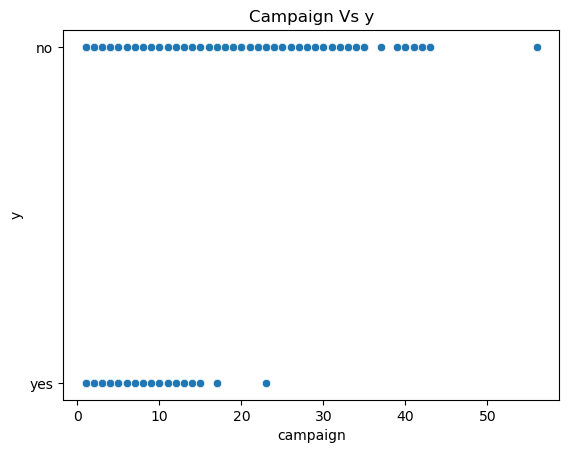

In [14]:
sns.scatterplot(data=df, x='campaign' , y='y')
plt.title('Campaign Vs y')

Text(0.5, 1.0, 'y Vs euribor3m')

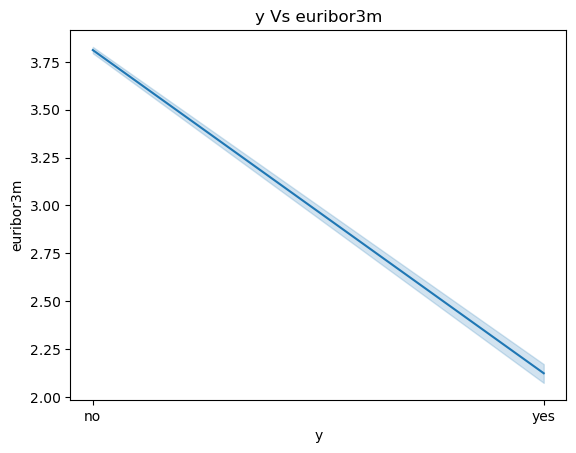

In [15]:
sns.lineplot(data=df, x='y', y='euribor3m')
plt.title('y Vs euribor3m')

Text(0.5, 1.0, 'Euribor3m Vs y')

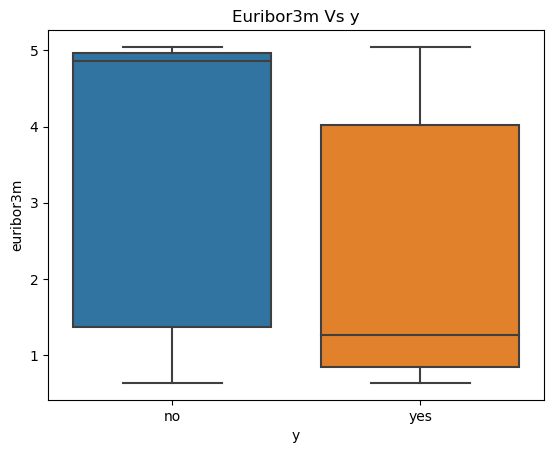

In [87]:
sns.boxplot(data=df, x='y', y='euribor3m')
plt.title('Euribor3m Vs y')

Text(0.5, 1.0, 'Month Vs y')

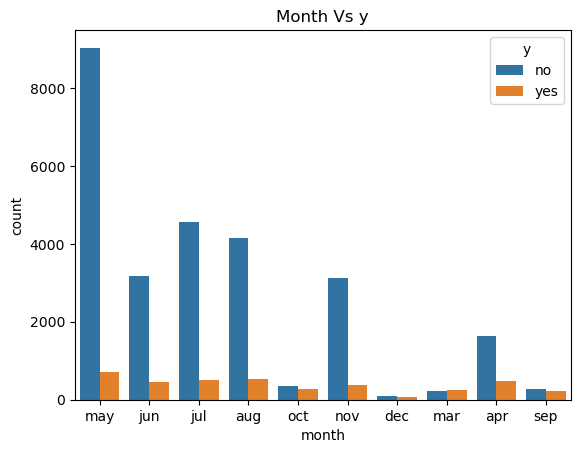

In [95]:
sns.countplot(data=df, x='month', hue='y')
plt.title('Month Vs y')

Text(0.5, 1.0, 'y Vs age')

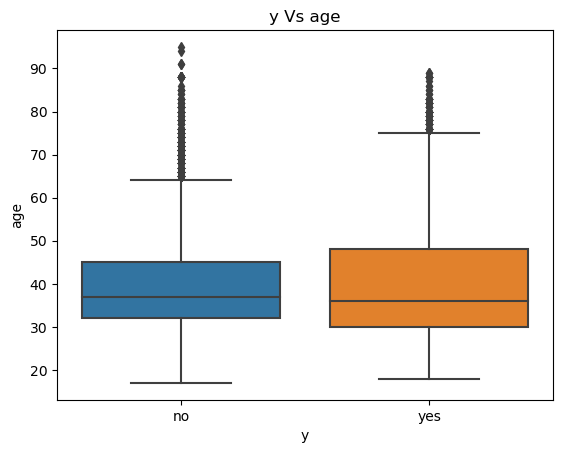

In [97]:
sns.boxplot(data=df, x='y', y='age')
plt.title('y Vs age')

Text(0.5, 1.0, 'y Vs cons.price.idx')

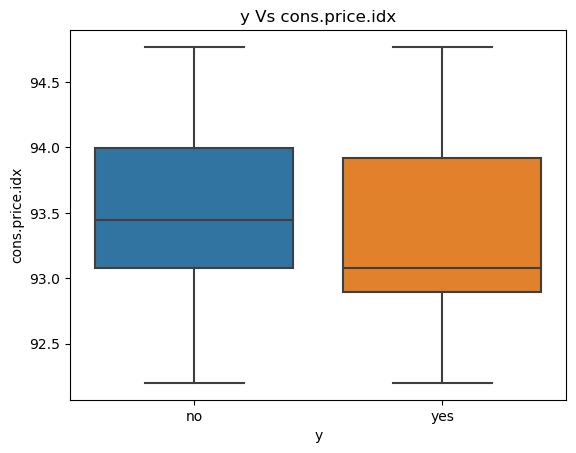

In [94]:
sns.boxplot(data=df, x='y', y='cons.price.idx')
plt.title('y Vs cons.price.idx')

Text(0.5, 1.0, 'y Vs cons.conf.idx')

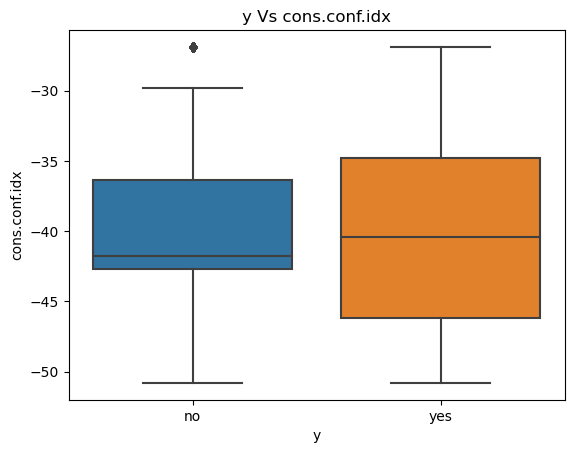

In [93]:
sns.boxplot(data=df, x='y', y='cons.conf.idx')
plt.title('y Vs cons.conf.idx')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'basic.4y'),
  Text(1, 0, 'high.school'),
  Text(2, 0, 'basic.6y'),
  Text(3, 0, 'professional.course'),
  Text(4, 0, 'basic.9y'),
  Text(5, 0, 'university.degree'),
  Text(6, 0, 'illiterate')])

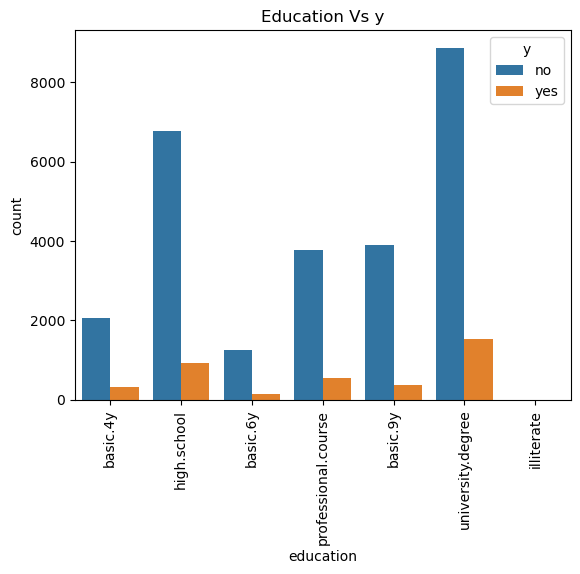

In [92]:
sns.countplot(data=df, x='education', hue='y')
plt.title('Education Vs y')
plt.xticks(rotation=90)

(array([0, 1, 2]),
 [Text(0, 0, 'married'), Text(1, 0, 'single'), Text(2, 0, 'divorced')])

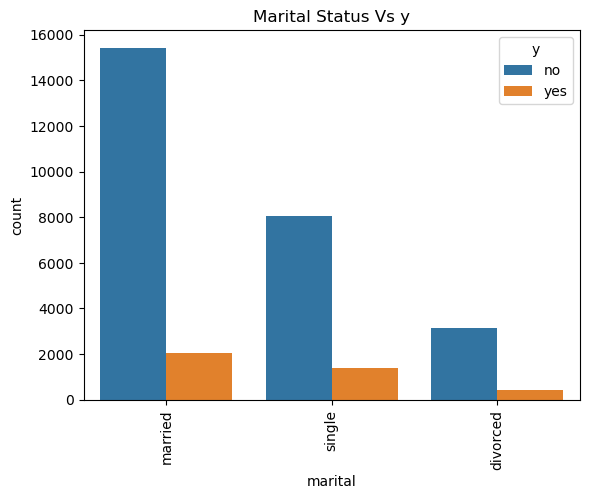

In [98]:
sns.countplot(data=df, x='marital', hue='y')
plt.title('Marital Status Vs y')
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'no'), Text(1, 0, 'yes')])

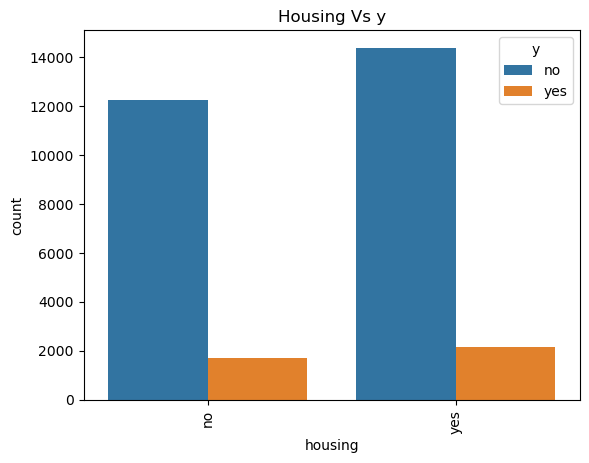

In [99]:
sns.countplot(data=df, x='housing', hue='y')
plt.title('Housing Vs y')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'y Vs emp.var.rate')

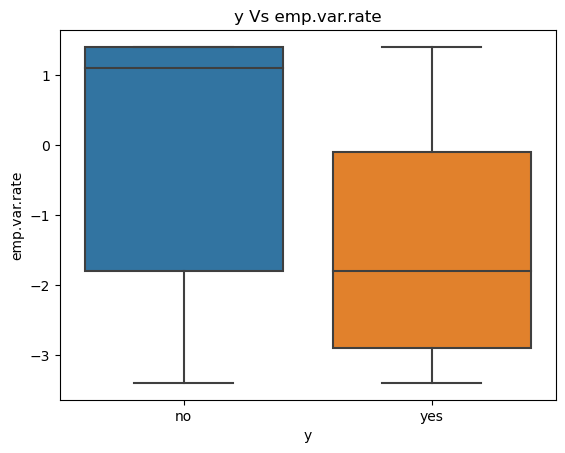

In [102]:
sns.boxplot(data=df, x='y', y='emp.var.rate')
plt.title('y Vs emp.var.rate')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Based on inputs on customer, bank and campaign calls, predict if the customer is bound to sign up for term deposit. Compare classifiers and recommend the best one for the task.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  campaign        41176 non-null  int64  
 11  pdays           41176 non-null  int64  
 12  previous        41176 non-null  int64  
 13  poutcome        41176 non-null  object 
 14  emp.var.rate    41176 non-null  float64
 15  cons.price.idx  41176 non-null  float64
 16  cons.conf.idx   41176 non-null  float64
 17  euribor3m       41176 non-null  floa

In [24]:
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp.var.rate'}>,
        <Axes: title={'center': 'cons.price.idx'}>],
       [<Axes: title={'center': 'cons.conf.idx'}>,
        <Axes: title={'center': 'euribor3m'}>,
        <Axes: title={'center': 'nr.employed'}>]], dtype=object)

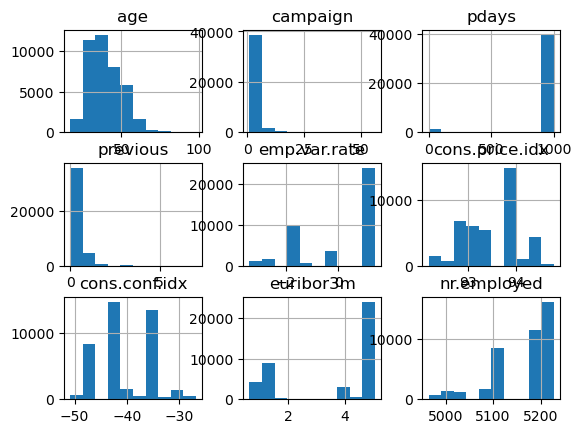

In [25]:
df.hist()

In [26]:
for col in df.select_dtypes(include = 'object').columns:
    print(df[col].value_counts().to_markdown())

| job           |   count |
|:--------------|--------:|
| admin.        |   10419 |
| blue-collar   |    9253 |
| technician    |    6739 |
| services      |    3967 |
| management    |    2924 |
| retired       |    1718 |
| entrepreneur  |    1456 |
| self-employed |    1421 |
| housemaid     |    1060 |
| unemployed    |    1014 |
| student       |     875 |
| unknown       |     330 |
| marital   |   count |
|:----------|--------:|
| married   |   24921 |
| single    |   11564 |
| divorced  |    4611 |
| unknown   |      80 |
| education           |   count |
|:--------------------|--------:|
| university.degree   |   12164 |
| high.school         |    9512 |
| basic.9y            |    6045 |
| professional.course |    5240 |
| basic.4y            |    4176 |
| basic.6y            |    2291 |
| unknown             |    1730 |
| illiterate          |      18 |
| default   |   count |
|:----------|--------:|
| no        |   32577 |
| unknown   |    8596 |
| yes       |       3 |
| ho

In [27]:
for col in df.select_dtypes(include = 'object').columns:
    cond = (df[col] == 'unknown')
    df[col] = np.where(cond, np.nan, df[col])
    print(df[col].value_counts().to_markdown())

| job           |   count |
|:--------------|--------:|
| admin.        |   10419 |
| blue-collar   |    9253 |
| technician    |    6739 |
| services      |    3967 |
| management    |    2924 |
| retired       |    1718 |
| entrepreneur  |    1456 |
| self-employed |    1421 |
| housemaid     |    1060 |
| unemployed    |    1014 |
| student       |     875 |
| marital   |   count |
|:----------|--------:|
| married   |   24921 |
| single    |   11564 |
| divorced  |    4611 |
| education           |   count |
|:--------------------|--------:|
| university.degree   |   12164 |
| high.school         |    9512 |
| basic.9y            |    6045 |
| professional.course |    5240 |
| basic.4y            |    4176 |
| basic.6y            |    2291 |
| illiterate          |      18 |
| default   |   count |
|:----------|--------:|
| no        |   32577 |
| yes       |       3 |
| housing   |   count |
|:----------|--------:|
| yes       |   21571 |
| no        |   18615 |
| loan   |   count

In [28]:
df = df.dropna()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30478 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30478 non-null  int64  
 1   job             30478 non-null  object 
 2   marital         30478 non-null  object 
 3   education       30478 non-null  object 
 4   default         30478 non-null  object 
 5   housing         30478 non-null  object 
 6   loan            30478 non-null  object 
 7   contact         30478 non-null  object 
 8   month           30478 non-null  object 
 9   day_of_week     30478 non-null  object 
 10  campaign        30478 non-null  int64  
 11  pdays           30478 non-null  int64  
 12  previous        30478 non-null  int64  
 13  poutcome        30478 non-null  object 
 14  emp.var.rate    30478 non-null  float64
 15  cons.price.idx  30478 non-null  float64
 16  cons.conf.idx   30478 non-null  float64
 17  euribor3m       30478 non-null  floa

In [30]:
for col in df.select_dtypes(include = 'object').columns:
    print(df[col].value_counts())

job
admin.           8734
blue-collar      5674
technician       5469
services         2856
management       2311
retired          1215
self-employed    1092
entrepreneur     1089
unemployed        738
housemaid         690
student           610
Name: count, dtype: int64
marital
married     17487
single       9439
divorced     3552
Name: count, dtype: int64
education
university.degree      10408
high.school             7697
professional.course     4318
basic.9y                4276
basic.4y                2380
basic.6y                1388
illiterate                11
Name: count, dtype: int64
default
no     30475
yes        3
Name: count, dtype: int64
housing
yes    16516
no     13962
Name: count, dtype: int64
loan
no     25710
yes     4768
Name: count, dtype: int64
contact
cellular     20435
telephone    10043
Name: count, dtype: int64
month
may    9731
jul    5077
aug    4672
jun    3614
nov    3495
apr    2114
oct     641
sep     495
mar     482
dec     157
Name: count, dtype: int64


In [31]:
df['education'].value_counts()

education
university.degree      10408
high.school             7697
professional.course     4318
basic.9y                4276
basic.4y                2380
basic.6y                1388
illiterate                11
Name: count, dtype: int64

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [32]:
ohe = OneHotEncoder(drop = 'if_binary', sparse_output=False, handle_unknown="ignore")

ct = ColumnTransformer(transformers=[
    ("ohe", ohe, df.select_dtypes(include = 'object').columns)],
    remainder='passthrough', verbose_feature_names_out=False
)

ct.set_output(transform="pandas")
df_transformed = ct.fit_transform(df)
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30478 entries, 0 to 41187
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   job_admin.                     30478 non-null  float64
 1   job_blue-collar                30478 non-null  float64
 2   job_entrepreneur               30478 non-null  float64
 3   job_housemaid                  30478 non-null  float64
 4   job_management                 30478 non-null  float64
 5   job_retired                    30478 non-null  float64
 6   job_self-employed              30478 non-null  float64
 7   job_services                   30478 non-null  float64
 8   job_student                    30478 non-null  float64
 9   job_technician                 30478 non-null  float64
 10  job_unemployed                 30478 non-null  float64
 11  marital_divorced               30478 non-null  float64
 12  marital_married                30478 non-null  floa

In [33]:
'''le = LabelEncoder()
df_transformed['job'] = le.fit_transform(df_transformed['job'])
df_transformed['education'] = le.fit_transform(df_transformed['education'])
df_transformed['day_of_week'] = le.fit_transform(df_transformed['day_of_week'])
df_transformed['month'] = le.fit_transform(df_transformed['month'])
df_transformed.info()'''

"le = LabelEncoder()\ndf_transformed['job'] = le.fit_transform(df_transformed['job'])\ndf_transformed['education'] = le.fit_transform(df_transformed['education'])\ndf_transformed['day_of_week'] = le.fit_transform(df_transformed['day_of_week'])\ndf_transformed['month'] = le.fit_transform(df_transformed['month'])\ndf_transformed.info()"

In [34]:
for col in df_transformed.columns:
    print(df_transformed[col].value_counts())

job_admin.
0.0    21744
1.0     8734
Name: count, dtype: int64
job_blue-collar
0.0    24804
1.0     5674
Name: count, dtype: int64
job_entrepreneur
0.0    29389
1.0     1089
Name: count, dtype: int64
job_housemaid
0.0    29788
1.0      690
Name: count, dtype: int64
job_management
0.0    28167
1.0     2311
Name: count, dtype: int64
job_retired
0.0    29263
1.0     1215
Name: count, dtype: int64
job_self-employed
0.0    29386
1.0     1092
Name: count, dtype: int64
job_services
0.0    27622
1.0     2856
Name: count, dtype: int64
job_student
0.0    29868
1.0      610
Name: count, dtype: int64
job_technician
0.0    25009
1.0     5469
Name: count, dtype: int64
job_unemployed
0.0    29740
1.0      738
Name: count, dtype: int64
marital_divorced
0.0    26926
1.0     3552
Name: count, dtype: int64
marital_married
1.0    17487
0.0    12991
Name: count, dtype: int64
marital_single
0.0    21039
1.0     9439
Name: count, dtype: int64
education_basic.4y
0.0    28098
1.0     2380
Name: count, dtype: i

job_admin.                       0.023880
job_blue-collar                 -0.067493
job_entrepreneur                -0.019589
job_housemaid                   -0.000227
job_management                  -0.002435
job_retired                      0.102490
job_self-employed               -0.003307
job_services                    -0.035053
job_student                      0.088626
job_technician                  -0.013188
job_unemployed                   0.020916
marital_divorced                -0.012185
marital_married                 -0.031638
marital_single                   0.042295
education_basic.4y               0.009096
education_basic.6y              -0.018789
education_basic.9y              -0.045821
education_high.school           -0.009155
education_illiterate             0.008351
education_professional.course   -0.002430
education_university.degree      0.046512
default_yes                     -0.003777
housing_yes                      0.010171
loan_yes                        -0

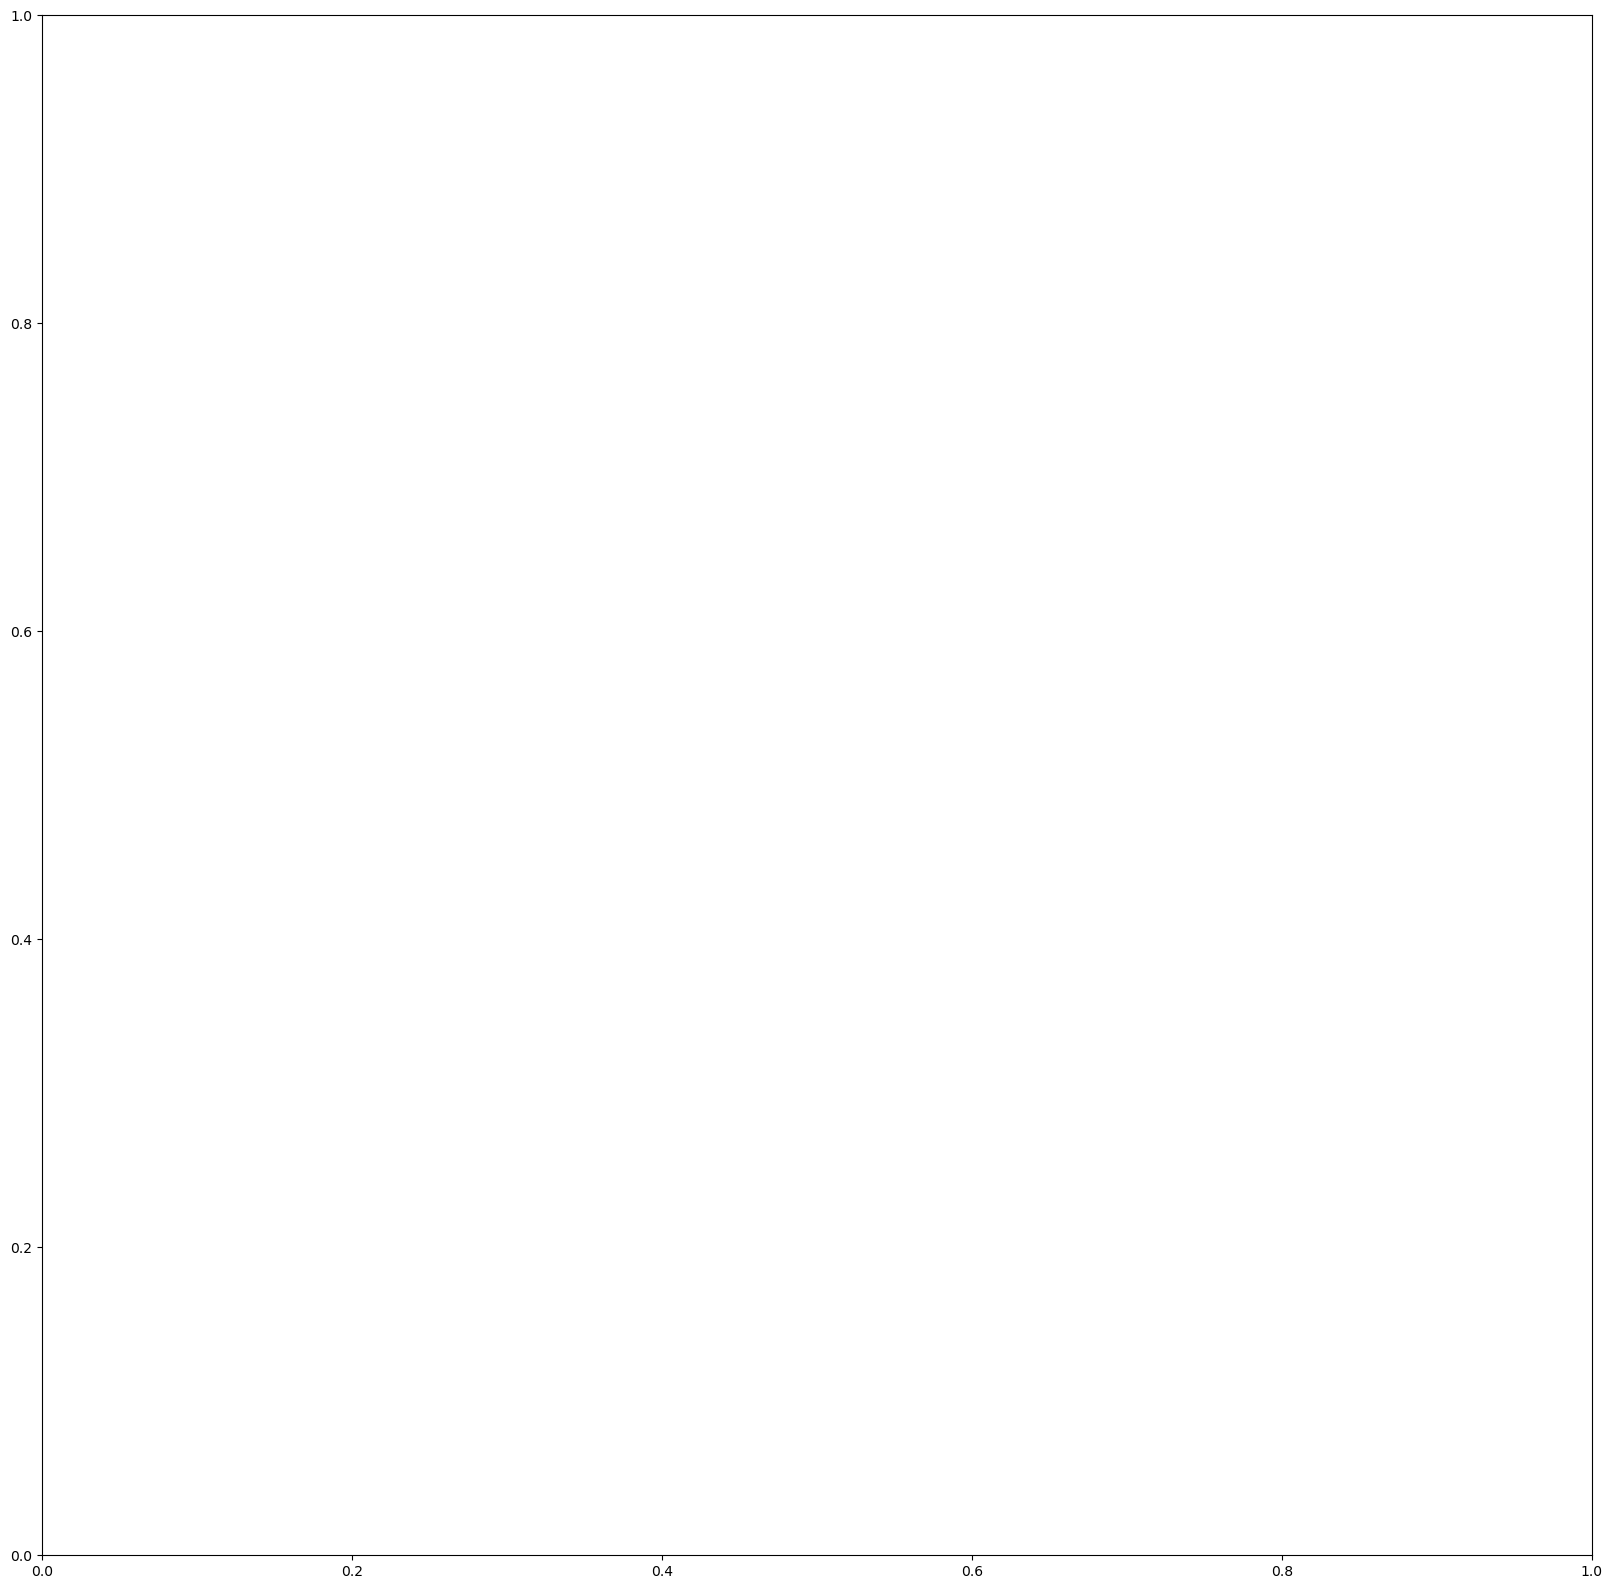

In [35]:
corr = df_transformed.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
#sns.heatmap(corr['y_yes'], annot=True, ax=ax)
#plt.title('Heatmap')
print(corr['y_yes'])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [36]:
from sklearn.utils import shuffle
shuffled_data = shuffle(df_transformed, random_state=42)
X = df_transformed.drop(columns=['y_yes'], axis=1)
y = df_transformed['y_yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=22, shuffle=True, stratify=y)

In [37]:
X_train.shape

(24382, 52)

In [38]:
y_train.value_counts()

y_yes
0.0    21296
1.0     3086
Name: count, dtype: int64

In [39]:
X_test.shape

(6096, 52)

In [40]:
y_test.value_counts()

y_yes
0.0    5324
1.0     772
Name: count, dtype: int64

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [41]:
y.value_counts()

y_yes
0.0    26620
1.0     3858
Name: count, dtype: int64

In [42]:
dummy_pipe = Pipeline([('scaler', StandardScaler()),
                      ('baseline', DummyClassifier(strategy='stratified',random_state=42))])
dummy_pipe.fit(X_train, y_train)
print(classification_report(y_test, dummy_pipe.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88      5324
         1.0       0.13      0.13      0.13       772

    accuracy                           0.78      6096
   macro avg       0.50      0.50      0.50      6096
weighted avg       0.78      0.78      0.78      6096



Text(0.5, 1.0, 'Baseline ROC Curve')

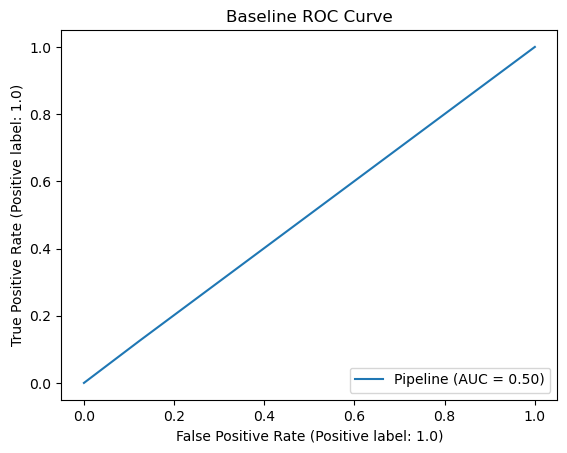

In [43]:
RocCurveDisplay.from_estimator(dummy_pipe, X_test, y_test)
plt.title('Baseline ROC Curve')

#### Unbalanced dataset. If the baseline was to predict the majority class, we get zero recall score. Recall score for value 1 is very important for our classification problem. We want to correctly identify all candidates who will accept term deposit. DummyClassifier with stratified option would be a better baseline model even though the recall score is very less.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [44]:
import time
lgr_pipe = Pipeline([('scaler', StandardScaler()),
                      ('lgr', LogisticRegression(random_state=42))])
start = time.time()
lgr_pipe.fit(X_train, y_train)
fit_time_lgr = time.time() - start

### Problem 9: Score the Model

What is the accuracy of your model?

In [45]:
report = classification_report(y_test, lgr_pipe.predict(X_test), output_dict=True)
recall_lgr = report['1.0']['recall']
pres_lgr = report['1.0']['precision']
recall_lgr

0.24481865284974094

In [46]:
train_acc_lgr= accuracy_score(y_train, lgr_pipe.predict(X_train))
test_acc_lgr = accuracy_score(y_test, lgr_pipe.predict(X_test))

#### Definitely better than baseline but recall/precision needs to be improved further

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [47]:

svc_pipe = Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC(probability=True))])
start = time.time()
svc_pipe.fit(X_train, y_train)
fit_time_svc = time.time() - start

In [48]:
report = classification_report(y_test, svc_pipe.predict(X_test), output_dict=True)
recall_svc = report['1.0']['recall']
pres_svc = report['1.0']['precision']
recall_svc

0.24870466321243523

In [49]:
train_acc_svc= accuracy_score(y_train, svc_pipe.predict(X_train))
test_acc_svc = accuracy_score(y_test, svc_pipe.predict(X_test))

In [50]:
dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree', DecisionTreeClassifier())])
start = time.time()
dtree_pipe.fit(X_train, y_train)
fit_time_dtree = time.time() - start

In [51]:
report = classification_report(y_test, dtree_pipe.predict(X_test), output_dict=True)
recall_dtree = report['1.0']['recall']
pres_dtree = report['1.0']['precision']
recall_dtree

0.3238341968911917

In [52]:
train_acc_dtree = accuracy_score(y_train, dtree_pipe.predict(X_train))
test_acc_dtree = accuracy_score(y_test, dtree_pipe.predict(X_test))

In [53]:
knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())])
start = time.time()
knn_pipe.fit(X_train, y_train)
fit_time_knn = time.time() - start

In [54]:
report = classification_report(y_test, knn_pipe.predict(X_test), output_dict=True)
recall_knn = report['1.0']['recall']
pres_knn = report['1.0']['precision']
recall_knn

0.2759067357512953

In [55]:
train_acc_knn = accuracy_score(y_train, knn_pipe.predict(X_train))
test_acc_knn = accuracy_score(y_test, knn_pipe.predict(X_test))

In [56]:
models = ["LogisticRegression","KNN", "DecisionTrees", "SVM"]
train_times = [fit_time_lgr, fit_time_knn, fit_time_dtree, fit_time_svc]
train_acc = [train_acc_lgr, train_acc_knn, train_acc_dtree, train_acc_svc]
test_acc = [test_acc_lgr, test_acc_knn, test_acc_dtree, test_acc_svc]

model_cmp_table = pd.DataFrame({'Model':models, 'Train Time': train_times, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc})
model_cmp_table.set_index('Model')

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.074832,0.889837,0.888615
KNN,0.011006,0.905545,0.879921
DecisionTrees,0.106130,0.994627,0.822671
SVM,60.345556,0.902305,0.887631


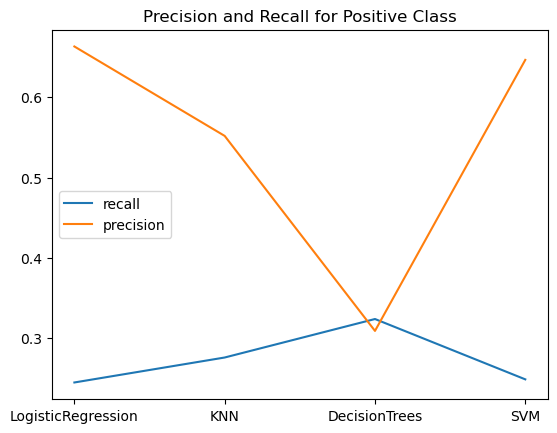

In [57]:
recall_pos = [recall_lgr, recall_knn, recall_dtree, recall_svc]
pres_pos = [pres_lgr, pres_knn, pres_dtree, pres_svc]
sns.lineplot(x=models, y=recall_pos, markers="o", label='recall')
sns.lineplot(x=models, y=pres_pos, label='precision')
plt.title('Precision and Recall for Positive Class')
plt.legend()

Text(0, 0.5, 'TruePositiveRate(Recall)')

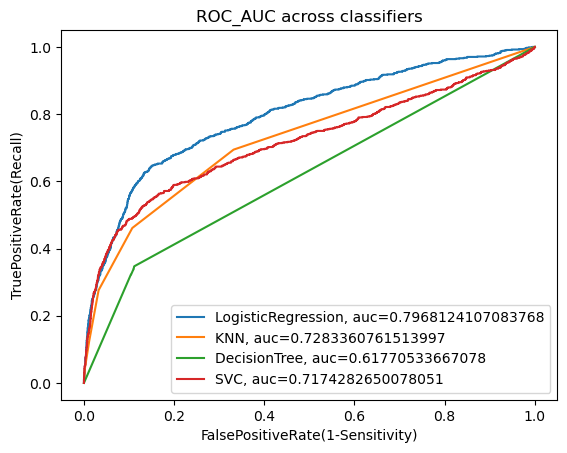

In [58]:
pred = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="LogisticRegression, auc="+str(auc))

pred = knn_pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

pred = dtree_pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

pred = svc_pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="SVC, auc="+str(auc))
plt.legend(loc=0)
plt.title("ROC_AUC across classifiers")
plt.xlabel('FalsePositiveRate(1-Sensitivity)')
plt.ylabel('TruePositiveRate(Recall)')

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Finding feature importance with original columns

In [59]:
X_train_prepped = pd.DataFrame(StandardScaler().fit_transform(X_train))
X_test_prepped = pd.DataFrame(StandardScaler().fit_transform(X_test))
model = LogisticRegression()
model.fit(X_train_prepped, y_train)

LogisticRegression()

In [60]:
r = permutation_importance(model, X_test_prepped, y_test,
                            n_repeats=50,
                            random_state=0)

r.importances_mean

array([ 3.28083990e-04, -3.93700787e-05,  3.28083990e-06,  6.23359580e-05,
        1.44356955e-04, -6.82414698e-04,  6.56167979e-06, -8.85826772e-05,
        2.29658793e-04,  0.00000000e+00,  1.90288714e-04,  1.90288714e-04,
       -9.51443570e-05,  4.26509186e-05,  5.24934383e-04,  2.95275591e-05,
        6.10236220e-04,  0.00000000e+00, -1.54199475e-04, -1.64041995e-05,
        5.44619423e-04,  3.28083990e-06,  3.67454068e-04, -7.54593176e-05,
        4.00918635e-03,  5.44619423e-04,  1.14829396e-03,  5.57742782e-05,
        5.11811024e-04,  1.25000000e-03,  1.51574803e-03,  1.14829396e-04,
        1.64041995e-04,  4.00262467e-04, -5.90551181e-05, -5.57742782e-05,
        4.98687664e-04,  6.82414698e-04,  2.82152231e-04, -3.60892388e-05,
        1.45669291e-03,  9.94094488e-04,  1.18438320e-03,  5.24934383e-05,
        7.64435696e-04,  1.08759843e-02,  6.72572178e-04,  1.99773622e-01,
        8.05577428e-02,  1.61745407e-03,  5.24278215e-03,  2.23097113e-02])

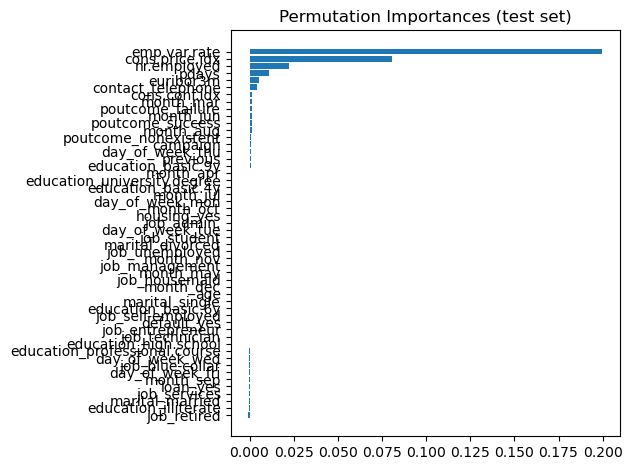

In [61]:
sorted_idx = r.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_train.columns[sorted_idx], r.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
fig.savefig('ImportanceForDegree1.png')
plt.show()

In [62]:
imp_cols = []
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         imp_cols.append(X_train.columns[i])
         print(f"{X_train.columns[i]:<8} --> "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

emp.var.rate --> 0.200 +/- 0.004
cons.price.idx --> 0.081 +/- 0.003
nr.employed --> 0.022 +/- 0.002
pdays    --> 0.011 +/- 0.001
euribor3m --> 0.005 +/- 0.001
contact_telephone --> 0.004 +/- 0.001
cons.conf.idx --> 0.002 +/- 0.001
month_mar --> 0.002 +/- 0.001
poutcome_failure --> 0.001 +/- 0.000
poutcome_success --> 0.001 +/- 0.000
poutcome_nonexistent --> 0.001 +/- 0.000
campaign --> 0.001 +/- 0.000
day_of_week_thu --> 0.001 +/- 0.000
previous --> 0.001 +/- 0.000
education_basic.9y --> 0.001 +/- 0.000
month_apr --> 0.001 +/- 0.000
education_basic.4y --> 0.001 +/- 0.000
job_unemployed --> 0.000 +/- 0.000


#### Using only the most important columns

In [63]:

X_imp = shuffled_data[imp_cols]
y_imp = shuffled_data['y_yes']
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp,y_imp,test_size=0.2, random_state=22, shuffle=True, stratify=y_imp)

In [64]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24382 entries, 15983 to 29675
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   emp.var.rate          24382 non-null  float64
 1   cons.price.idx        24382 non-null  float64
 2   nr.employed           24382 non-null  float64
 3   pdays                 24382 non-null  int64  
 4   euribor3m             24382 non-null  float64
 5   contact_telephone     24382 non-null  float64
 6   cons.conf.idx         24382 non-null  float64
 7   month_mar             24382 non-null  float64
 8   poutcome_failure      24382 non-null  float64
 9   poutcome_success      24382 non-null  float64
 10  poutcome_nonexistent  24382 non-null  float64
 11  campaign              24382 non-null  int64  
 12  day_of_week_thu       24382 non-null  float64
 13  previous              24382 non-null  int64  
 14  education_basic.9y    24382 non-null  float64
 15  month_apr           

In [65]:
import time
lgr_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('lgr', LogisticRegression(random_state=42))])
start = time.time()
lgr_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_lgr_imp = time.time() - start
y_pred = (lgr_pipe_imp.predict_proba(X_test_imp)[:,1] >= 0.3)
print(classification_report(y_test_imp, y_pred))
report = classification_report(y_test_imp, lgr_pipe_imp.predict(X_test_imp), output_dict=True)
recall_lgr_imp = report['1.0']['recall']
pres_lgr_imp = report['1.0']['precision']
train_acc_lgr_imp= accuracy_score(y_train_imp, lgr_pipe_imp.predict(X_train_imp))
test_acc_lgr_imp = accuracy_score(y_test_imp, lgr_pipe_imp.predict(X_test_imp))

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      5324
         1.0       0.49      0.44      0.47       772

    accuracy                           0.87      6096
   macro avg       0.71      0.69      0.70      6096
weighted avg       0.87      0.87      0.87      6096



In [66]:
knn_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('knn', KNeighborsClassifier())])
start = time.time()
knn_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_knn_imp = time.time() - start
report = classification_report(y_test_imp, knn_pipe_imp.predict(X_test_imp), output_dict=True)
recall_knn_imp = report['1.0']['recall']
pres_knn_imp = report['1.0']['precision']
train_acc_knn_imp= accuracy_score(y_train_imp, knn_pipe_imp.predict(X_train_imp))
test_acc_knn_imp = accuracy_score(y_test_imp, knn_pipe_imp.predict(X_test_imp))

In [67]:
dtree_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('dtree', DecisionTreeClassifier())])
start = time.time()
dtree_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_dtree_imp = time.time() - start
report = classification_report(y_test_imp, dtree_pipe_imp.predict(X_test_imp), output_dict=True)
recall_dtree_imp = report['1.0']['recall']
pres_dtree_imp = report['1.0']['precision']
train_acc_dtree_imp= accuracy_score(y_train_imp, dtree_pipe_imp.predict(X_train_imp))
test_acc_dtree_imp = accuracy_score(y_test_imp, dtree_pipe_imp.predict(X_test_imp))

In [68]:
svc_pipe_imp = Pipeline([('scaler', StandardScaler()),
                      ('svc', SVC())])
start = time.time()
svc_pipe_imp.fit(X_train_imp, y_train_imp)
fit_time_svc_imp = time.time() - start
report = classification_report(y_test_imp, svc_pipe_imp.predict(X_test_imp), output_dict=True)
recall_svc_imp = report['1.0']['recall']
pres_svc_imp = report['1.0']['precision']
train_acc_svc_imp= accuracy_score(y_train_imp, svc_pipe_imp.predict(X_train_imp))
test_acc_svc_imp = accuracy_score(y_test_imp, svc_pipe_imp.predict(X_test_imp))

In [69]:
models = ["LogisticRegression","KNN", "DecisionTrees", "SVM"]
train_times = [fit_time_lgr_imp, fit_time_knn_imp, fit_time_dtree_imp, fit_time_svc_imp]
train_acc = [train_acc_lgr_imp, train_acc_knn_imp, train_acc_dtree_imp, train_acc_svc_imp]
test_acc = [test_acc_lgr_imp, test_acc_knn_imp, test_acc_dtree_imp, test_acc_svc_imp]

model_cmp_table = pd.DataFrame({'Model':models, 'Train Time': train_times, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc})
model_cmp_table.set_index('Model')

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.025723,0.888688,0.885663
KNN,0.004576,0.898204,0.874016
DecisionTrees,0.032270,0.930482,0.874836
SVM,4.373687,0.892995,0.886155


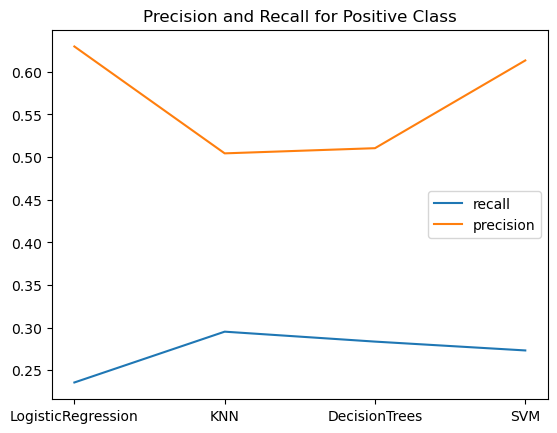

In [70]:
recall_pos = [recall_lgr_imp, recall_knn_imp, recall_dtree_imp, recall_svc_imp]
pres_pos = [pres_lgr_imp, pres_knn_imp, pres_dtree_imp, pres_svc_imp]
sns.lineplot(x=models, y=recall_pos, markers="o", label='recall')
sns.lineplot(x=models, y=pres_pos, label='precision')
plt.title('Precision and Recall for Positive Class')
plt.legend()

#### Logistic Regression with GridSearch

In [72]:
lgr_pipe = Pipeline([('scaler', StandardScaler()),
                     ('lgr', LogisticRegression(fit_intercept=True,random_state=42, max_iter=1000))])
params_to_try = {'lgr__C':np.logspace(0,10,50)}#, 'lgr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                #'lgr__penalty': ['l1', 'l2']}
lgr_grid = GridSearchCV(estimator=lgr_pipe, cv=5, param_grid=params_to_try, scoring='recall')
lgr_grid.fit(X_train_imp, y_train_imp)
report = classification_report(y_test_imp, lgr_grid.best_estimator_.predict(X_test_imp), output_dict=True)
recall_lgrgrid_imp = report['1.0']['recall']
pres_lgrgrid_imp = report['1.0']['precision']
train_acc_lgrgrid_imp= accuracy_score(y_train_imp, lgr_grid.best_estimator_.predict(X_train_imp))
test_acc_lgrgrid_imp = accuracy_score(y_test_imp, lgr_grid.best_estimator_.predict(X_test_imp))

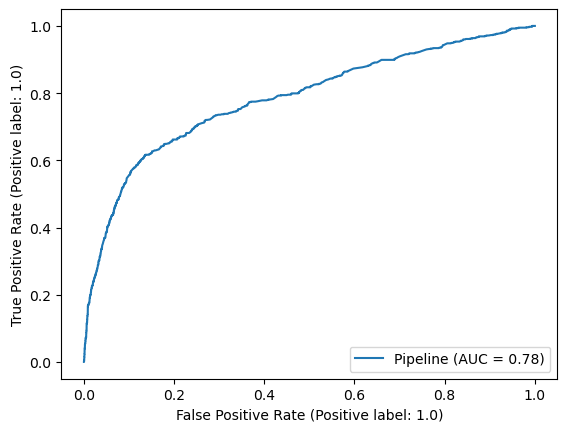

In [73]:
RocCurveDisplay.from_estimator(lgr_grid.best_estimator_, X_test_imp, y_test_imp)

#### Decision Tree with GrdiSearch

In [74]:
dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree', DecisionTreeClassifier())])
params_to_try = {'dtree__max_depth': range(1,20),
         'dtree__min_samples_split': [2,5,10],
          'dtree__criterion': ['gini', 'entropy'],
          'dtree__min_samples_leaf': range(1,5)
         }
dtree_grid = GridSearchCV(estimator=dtree_pipe, cv=5, param_grid=params_to_try, scoring='recall')
dtree_grid.fit(X_train_imp, y_train_imp)
report = classification_report(y_test_imp, dtree_grid.best_estimator_.predict(X_test_imp), output_dict=True)
recall_dtreegrid_imp = report['1.0']['recall']
pres_dtreegrid_imp = report['1.0']['precision']
train_acc_dtreegrid_imp= accuracy_score(y_train_imp, dtree_grid.best_estimator_.predict(X_train_imp))
test_acc_dtreegrid_imp = accuracy_score(y_test_imp, dtree_grid.best_estimator_.predict(X_test_imp))

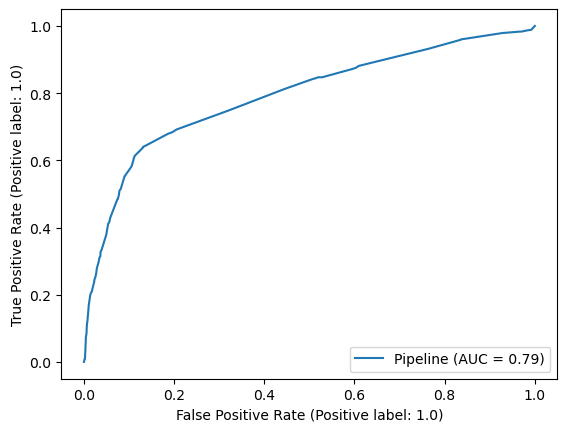

In [76]:
RocCurveDisplay.from_estimator(dtree_grid.best_estimator_, X_test_imp, y_test_imp)

In [77]:

#params = {'model__kernel': ['poly'], 'model__gamma': [0.1, 1.0, 10.0]}
svc_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', SVC(coef0=1, probability=True, kernel='poly'))])
#svc_grid = HalvingRandomSearchCV(estimator=svc_pipe, param_distributions=params, cv=5, scoring='recall')
svc_pipe.fit(X_train_imp, y_train_imp)
report = classification_report(y_test_imp, svc_pipe.predict(X_test_imp), output_dict=True)
recall_svcgrid_imp = report['1.0']['recall']
pres_svcgrid_imp = report['1.0']['precision']
train_acc_svcgrid_imp= accuracy_score(y_train_imp, svc_pipe.predict(X_train_imp))
test_acc_svcgrid_imp = accuracy_score(y_test_imp, svc_pipe.predict(X_test_imp))

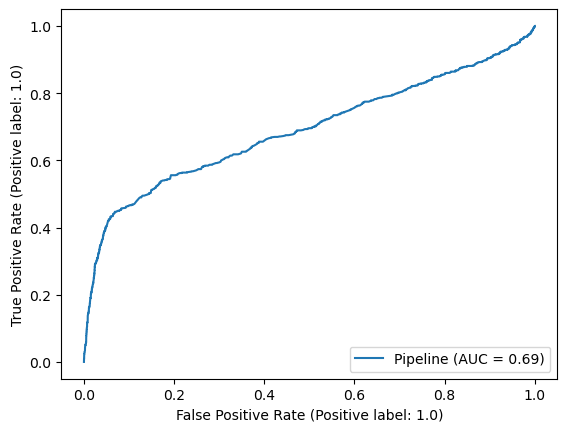

In [78]:
RocCurveDisplay.from_estimator(svc_pipe, X_test_imp, y_test_imp)

In [79]:
knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())])
params = {'knn__n_neighbors': [2,3,5,10,20,25,30,40]}#, 'knn__weights':['uniform', 'distance'],
         #'knn__metric': ['minowski', 'manhattan', 'cosine', 'l1', 'l2']}
knn_grid = GridSearchCV(estimator=knn_pipe, cv=5, param_grid = params, scoring='recall')
knn_grid.fit(X_train_imp, y_train_imp)
report = classification_report(y_test_imp, knn_grid.best_estimator_.predict(X_test_imp), output_dict=True)
recall_knngrid_imp = report['1.0']['recall']
pres_knngrid_imp = report['1.0']['precision']
train_acc_knngrid_imp= accuracy_score(y_train_imp, knn_grid.best_estimator_.predict(X_train_imp))
test_acc_knngrid_imp = accuracy_score(y_test_imp, knn_grid.best_estimator_.predict(X_test_imp))

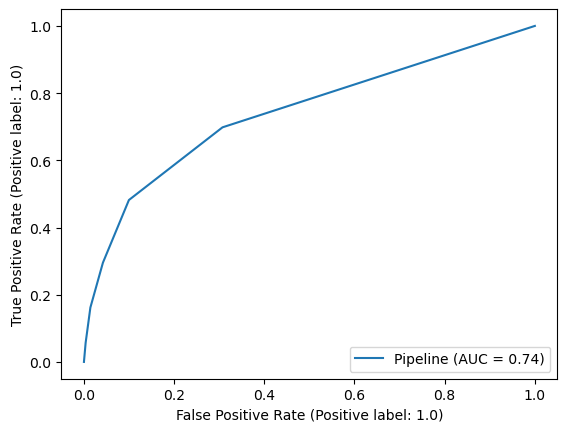

In [80]:
RocCurveDisplay.from_estimator(knn_grid.best_estimator_, X_test_imp, y_test_imp)

In [81]:
models = ["LogisticRegression","KNN", "DecisionTrees", "SVM"]
#train_times = [fit_time_lgrgrid_imp, fit_time_knngrid_imp, fit_time_dtreegrid_imp, fit_time_svcgrid_imp]
train_acc = [train_acc_lgrgrid_imp, train_acc_knngrid_imp, train_acc_dtreegrid_imp, train_acc_svcgrid_imp]
test_acc = [test_acc_lgrgrid_imp, test_acc_knngrid_imp, test_acc_dtreegrid_imp, test_acc_svcgrid_imp]
best_params = [lgr_grid.best_params_, knn_grid.best_params_, dtree_grid.best_params_, "{'kernel' = 'poly'}"]
model_cmp_table_grid = pd.DataFrame({'Model':models, "Best Params": best_params,'Train Accuracy': train_acc, 'Test Accuracy': test_acc})
model_cmp_table_grid.set_index('Model')
print(model_cmp_table_grid.to_markdown())

|    | Model              | Best Params                                                                                                       |   Train Accuracy |   Test Accuracy |
|---:|:-------------------|:------------------------------------------------------------------------------------------------------------------|-----------------:|----------------:|
|  0 | LogisticRegression | {'lgr__C': 1.599858719606058}                                                                                     |         0.888688 |        0.885663 |
|  1 | KNN                | {'knn__n_neighbors': 5}                                                                                           |         0.898204 |        0.874016 |
|  2 | DecisionTrees      | {'dtree__criterion': 'gini', 'dtree__max_depth': 8, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 10} |         0.897916 |        0.883038 |
|  3 | SVM                | {'kernel' = 'poly'}                                                

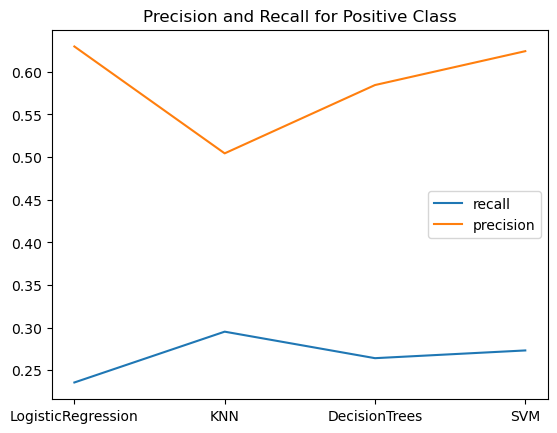

In [82]:
recall_pos = [recall_lgrgrid_imp, recall_knngrid_imp, recall_dtreegrid_imp, recall_svcgrid_imp]
pres_pos = [pres_lgrgrid_imp, pres_knngrid_imp, pres_dtreegrid_imp, pres_svcgrid_imp]
sns.lineplot(x=models, y=recall_pos, markers="o", label='recall')
sns.lineplot(x=models, y=pres_pos, label='precision')
plt.title('Precision and Recall for Positive Class')
plt.legend()

Text(0, 0.5, 'TruePositiveRate(Recall)')

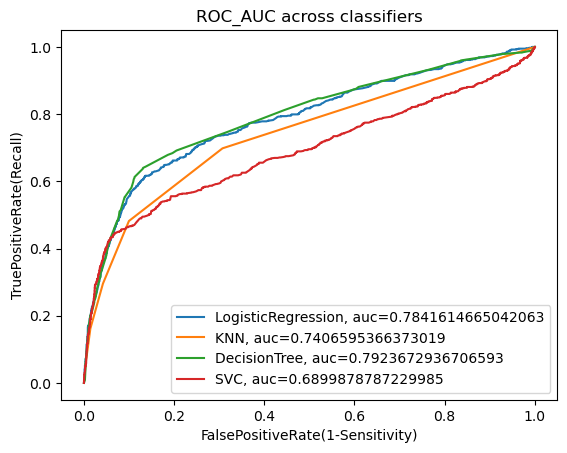

In [83]:
pred = lgr_grid.best_estimator_.predict_proba(X_test_imp)[:, 1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="LogisticRegression, auc="+str(auc))

pred = knn_grid.best_estimator_.predict_proba(X_test_imp)[:,1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

pred = dtree_grid.best_estimator_.predict_proba(X_test_imp)[:,1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

pred = svc_pipe.predict_proba(X_test_imp)[:,1]
fpr, tpr, thresh = roc_curve(y_test_imp, pred)
auc = roc_auc_score(y_test_imp, pred)
plt.plot(fpr,tpr,label="SVC, auc="+str(auc))
plt.legend(loc=0)
plt.title("ROC_AUC across classifiers")
plt.xlabel('FalsePositiveRate(1-Sensitivity)')
plt.ylabel('TruePositiveRate(Recall)')

#### Feature Importance with Polynomial Features

In [103]:
poly_ordinal_ohe_2 = make_column_transformer((PolynomialFeatures(degree=2, include_bias=False), make_column_selector(dtype_include=np.number)),
                                            (StandardScaler(), make_column_selector(dtype_include=np.number)))

X_train_prepped_2 = pd.DataFrame(poly_ordinal_ohe_2.fit_transform(X_train), columns= poly_ordinal_ohe_2.get_feature_names_out())
X_test_prepped_2 = pd.DataFrame(poly_ordinal_ohe_2.fit_transform(X_test), columns= poly_ordinal_ohe_2.get_feature_names_out())

model_2 = LogisticRegression(max_iter=5000)
model_2.fit(X_train_prepped_2, y_train)

LogisticRegression(max_iter=5000)

In [104]:
r = permutation_importance(model_2, X_test_prepped_2, y_test,
                            n_repeats=30,
                            random_state=0)

r.importances_mean

array([0., 0., 0., ..., 0., 0., 0.])

In [349]:
imp_cols_2 = []
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         imp_cols_2.append(poly_ordinal_ohe_2.get_feature_names_out()[i])
         print(f"{poly_ordinal_ohe_2.get_feature_names_out()[i]:<8} --> "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

polynomialfeatures__cons.price.idx nr.employed --> 0.022 +/- 0.002
polynomialfeatures__nr.employed^2 --> 0.019 +/- 0.002
polynomialfeatures__age pdays --> 0.005 +/- 0.001
polynomialfeatures__pdays^2 --> 0.005 +/- 0.001
polynomialfeatures__emp.var.rate nr.employed --> 0.003 +/- 0.001
polynomialfeatures__contact_telephone nr.employed --> 0.001 +/- 0.001
polynomialfeatures__month_mar nr.employed --> 0.001 +/- 0.000
polynomialfeatures__poutcome_success nr.employed --> 0.000 +/- 0.000


In [350]:
X_train_imp_2 = X_train_prepped_2[imp_cols_2]
X_test_imp_2 = X_test_prepped_2[imp_cols_2]


In [351]:
'''dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree', DecisionTreeClassifier())])
params_to_try = {'dtree__max_depth': range(1,16),
         'dtree__min_samples_split': [2,5,10],
          'dtree__criterion': ['gini', 'entropy'],
          'dtree__min_samples_leaf': range(1,5)
         }'''
params_to_try = {'max_depth': range(1,16),
         'min_samples_split': [2,5,10],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': range(1,5)
         }
dtree_grid = GridSearchCV(estimator=DecisionTreeClassifier(), cv=5, param_grid=params_to_try)
dtree_grid.fit(X_train_imp_2, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 16),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': [2, 5, 10]})

In [352]:
y_pred = (dtree_grid.best_estimator_.predict_proba(X_test_imp_2)[:,1] >= 0.3)

In [353]:
print(classification_report(y_test_imp, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      5324
         1.0       0.43      0.53      0.47       772

    accuracy                           0.85      6096
   macro avg       0.68      0.71      0.69      6096
weighted avg       0.87      0.85      0.86      6096



##### Questions